In [1]:
import torch
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
x0 = torch.tensor([[0.],[0.],[1.],[0.]], device=device)

dt, qc = 0.01, 0.1

F  = torch.tensor([
    [1., 0., dt, 0.],
    [0., 1., 0., 1.],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.]
], device=device)

Q = torch.tensor([
    [qc*(dt**3)/3, 0.,           qc*(dt**2)/2, 0.],
    [0.,           qc*(dt**3)/3, 0.,           qc*(dt**2)/2],
    [qc*(dt**2)/2, 0.,           qc*dt,        0.],
    [0.,           qc*(dt**2)/2, 0.,           qc*dt]
], device=device)

Q_chol = torch.cholesky(Q);

H = torch.tensor([
    [1., 0., 0., 0.],
    [0., 1., 0., 0.]
], device=device)

R = 0.625*torch.eye(2, device=device);
R_chol = 0.25*torch.eye(2, device=device);

In [4]:
xs,ys,ix = [], [], []
xi = x0


for i in range(1000):
    xi = F@xi + Q_chol @ torch.randn(4,1, device=device)
    xs.append(xi)
    if i % 50 == 0:
        ys.append(H@xi + R_chol @ torch.randn(2,1, device=device))
        ix.append(i)

ts = torch.arange(0., dt*1000., step=dt, device=device)
xs = torch.stack(xs, 0);
ys = torch.stack(ys, 0);

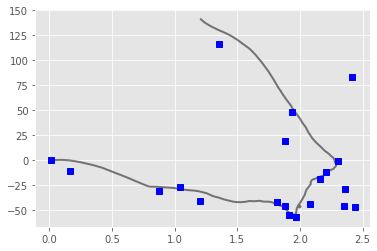

In [5]:
plt.plot(xs[:,0,0].cpu(),xs[:,1,:].cpu(),'k-', alpha=0.5, lw=2)
plt.plot(ys[:,0,0].cpu(),ys[:,1,:].cpu(),'bs')

In [6]:
from torchfilter.filters import KalmanFilter

In [7]:
kf = KalmanFilter(F, H, Q, R, device=device)

In [8]:
xf, Pf = kf.filter(ts, ys, {'x0':x0, 'P0':Q, 'obs_index':ix})

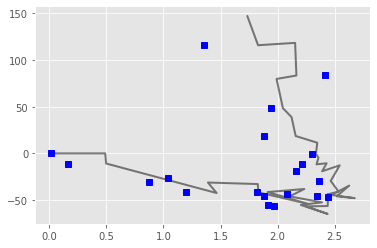

In [9]:
plt.plot(xf[:,0,:].cpu(),xf[:,1,:].cpu(),'k-', alpha=0.5, lw=2)
plt.plot(ys[:,0,0].cpu(),ys[:,1,:].cpu(),'bs')

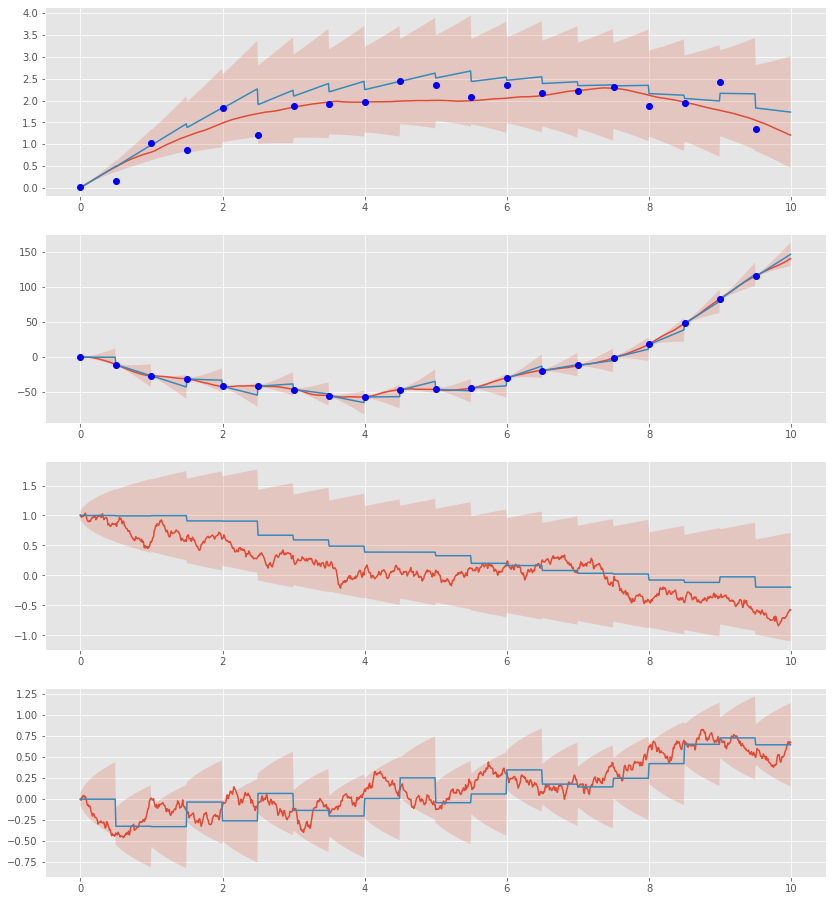

In [10]:
_,axs = plt.subplots(4,1,figsize=(14,16))

for i in range(4):
    mu = xf[:,i,:].view(-1).cpu()
    sd = torch.sqrt(Pf[:,i,i]).view(-1).cpu()
    axs[i].fill_between(ts.cpu(), mu - 1.96*sd, mu + 1.96*sd,alpha=0.2)
    axs[i].plot(ts.cpu(),xs[:,i,:].cpu())
    axs[i].plot(ts.cpu(),mu)
    if i < 2:
        axs[i].plot(ts.cpu()[ix], ys[:,i,:].cpu(), 'bo')
    

In [11]:
from torchfilter.smoothers import RauchTungStriebelSmoother


In [12]:
rts = RauchTungStriebelSmoother.from_filter(kf)

xt, Pt, Gt = rts.smooth(xf[...,0:ix[-1]+1,:,:], Pf[...,0:ix[-1]+1,:,:], return_gain=True)
xt = torch.cat([xt, xf[...,ix[-1]+1:,:,:]],-3)
Pt = torch.cat([Pt, Pf[...,ix[-1]+1:,:,:]],-3)

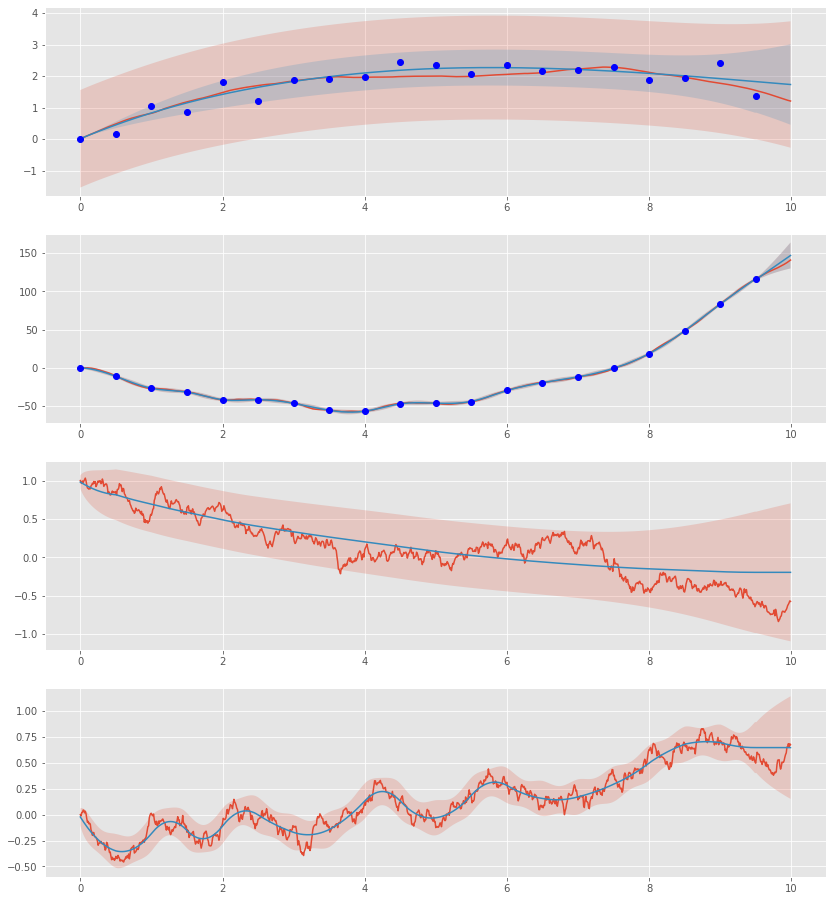

In [13]:
_,axs = plt.subplots(4,1,figsize=(14,16))

for i in range(4):
    mu = xt[:,i,:].view(-1).cpu()
    if i < 2:
        sd = torch.sqrt(Pt[:,i,i] + R[...,i,i]).view(-1).cpu()
        axs[i].fill_between(ts.cpu(), mu - 1.96*sd, mu + 1.96*sd,alpha=0.2)
    sd = torch.sqrt(Pt[:,i,i]).view(-1).cpu()
    axs[i].fill_between(ts.cpu(), mu - 1.96*sd, mu + 1.96*sd,alpha=0.2)
    axs[i].plot(ts.cpu(),xs[:,i,:].cpu())
    axs[i].plot(ts.cpu(),mu)
    if i < 2:
        axs[i].plot(ts[ix].cpu(), ys[:,i,:].cpu(), 'bo')

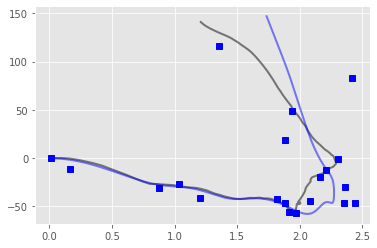

In [14]:
plt.plot(xs[:,0,:].cpu(),xs[:,1,:].cpu(),'k-', alpha=0.5, lw=2)
plt.plot(xt[:,0,:].cpu(),xt[:,1,:].cpu(),'b-', alpha=0.5, lw=2)
plt.plot(ys[:,0,0].cpu(),ys[:,1,:].cpu(),'bs')

In [15]:
def sample(m, P, G=[], n=1):
    dims = [*m.shape[:-4],*m.shape[-2:]]
    xn = [m[...,0,:,:] + torch.cholesky(P[...,0,:,:])@torch.randn(n,*dims,device=device)]
    for i in range(1, m.shape[-3]):
        xi = xn[-1]
        
        mu_, mu = m[...,i-1,:,:], m[...,i,:,:]
        Sigma_, Sigma = P[...,i-1,:,:], P[...,i,:,:]
        
        if i > len(G):
            mu_cond  = F@xi
            Sig_cond = Q#Sigma#F@Sigma_@F.transpose(-1,-2) + Q
        else:
            Prec_ = torch.inverse(Sigma_)
            G_T = G[i-1].transpose(-1,-2)

            PG = Sigma @ G_T

            mu_cond = mu + PG @ Prec_ @ (xi - mu_)
            Sig_cond = Sigma - PG @ Prec_ @ PG.transpose(-1,-2)
#             for i in range(dims[0]):
#                 Sig_cond[i,i] = torch.abs(Sig_cond[i,i]) + 1e-8
#             print(Sig_cond)
        xn.append(mu_cond + torch.cholesky(Sig_cond+1e-4*torch.eye(dims[-2], device=device))@torch.randn(n,*dims,device=device))
    return torch.stack(xn,-3)

In [16]:
sample(xt,Pt,Gt,n=10).shape

torch.Size([10, 1000, 4, 1])

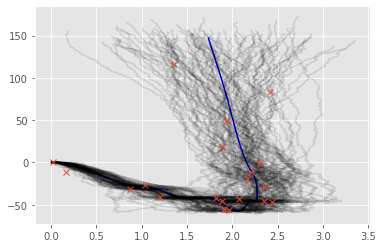

In [17]:

plt.plot(xt[:,0,:].cpu(),xt[:,1,:].cpu(),'b-', alpha=1)
# for i in range(10):
#     xn = sample(xt, Pt, Gt)
xn = sample(xt, Pt, Gt, n=100)
for i in range(xn.shape[0]):
    plt.plot(xn[i,:,0,:].cpu(), xn[i,:,1,:].cpu(),'k-',alpha=0.1)
plt.plot(ys[:,0,:].cpu(),ys[:,1,:].cpu(),'x')

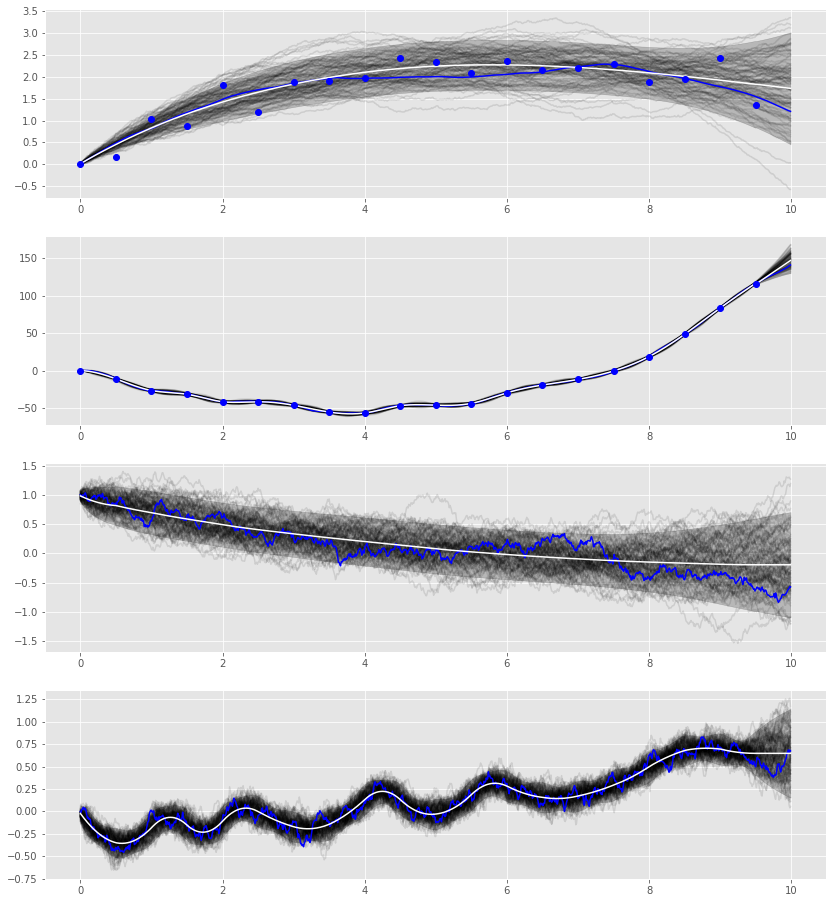

In [18]:
samples = sample(xt,Pt,Gt, n=100)

_,axs = plt.subplots(4,1,figsize=(14,16))

for i in range(4):
    for j in range(100):
        axs[i].plot(ts.cpu(), samples[j,:,i,:].cpu(),'k-', alpha=0.1)
    mu = xt[:,i,:].view(-1).cpu()
    sd = torch.sqrt(Pt[:,i,i]).view(-1).cpu()  
    axs[i].fill_between(ts.cpu(), mu - 1.96*sd, mu + 1.96*sd,color='k',alpha=0.2)
    axs[i].plot(ts.cpu(), xs[:,i,:].cpu(), 'b-')
    axs[i].plot(ts.cpu(), mu,'w')
    if i < 2:
        axs[i].plot(ts[ix].cpu(), ys[:,i,:].cpu(), 'bo')